# Wind Stress & Kinetic Energy — NEMO GYRE

- Wind stress quiver plot
- Total kinetic energy time series

In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16, "axes.titlesize": 18, "axes.labelsize": 14})
import numpy as np
import xarray as xr

OUTPUT_DIR = Path("../output")
ds_t = xr.open_dataset(
    OUTPUT_DIR / "GYRE_10d_00010101_00021230_grid_T_0000.nc", decode_times=False
)
ds_u = xr.open_dataset(
    OUTPUT_DIR / "GYRE_10d_00010101_00021230_grid_U_0000.nc", decode_times=False
)
ds_v = xr.open_dataset(
    OUTPUT_DIR / "GYRE_10d_00010101_00021230_grid_V_0000.nc", decode_times=False
)
mm = xr.open_dataset(OUTPUT_DIR / "mesh_mask.nc")

tmask = mm["tmask"].isel(time_counter=0).values          # (z, y, x)
tmask_sfc = tmask[0]
e1t = mm["e1t"].isel(time_counter=0).values               # (y, x)
e2t = mm["e2t"].isel(time_counter=0).values               # (y, x)
e3t = mm["e3t_1d"].isel(time_counter=0).values            # (z,)
cell_area = e1t * e2t

# Grid rotation angle from glamt/gphit
glamt = mm["glamt"].isel(time_counter=0).values
gphit = mm["gphit"].isel(time_counter=0).values
dx_lon = np.diff(glamt, axis=1)
dx_lat = np.diff(gphit, axis=1)
dx_lon = np.concatenate([dx_lon, dx_lon[:, -1:]], axis=1)
dx_lat = np.concatenate([dx_lat, dx_lat[:, -1:]], axis=1)
grid_angle = np.arctan2(dx_lat, dx_lon)

def rotate_to_geo(ui, vj, angle):
    """Rotate (i,j)-aligned vectors to geographic (east, north)."""
    cos_a = np.cos(angle)
    sin_a = np.sin(angle)
    u_east  = ui * cos_a - vj * sin_a
    v_north = ui * sin_a + vj * cos_a
    return u_east, v_north

# Interior mask (1-cell border for T-grid, 2-cell for velocities)
interior_t = tmask_sfc.copy()
interior_t[0, :] = 0; interior_t[-1, :] = 0
interior_t[:, 0] = 0; interior_t[:, -1] = 0

interior_uv = tmask_sfc.copy()
interior_uv[:2, :] = 0; interior_uv[-2:, :] = 0
interior_uv[:, :2] = 0; interior_uv[:, -2:] = 0

# Cartopy
MARGIN = 0.5
lon, lat = ds_t.nav_lon.values, ds_t.nav_lat.values
proj = ccrs.Stereographic(central_longitude=-68, central_latitude=32)
extent = [lon.min() - MARGIN, lon.max() + MARGIN,
          lat.min() - MARGIN, lat.max() + MARGIN]

time_days = (ds_t.time_counter.values - ds_t.time_counter.values[0]) / 86400.0

## Wind stress

Time-mean wind stress vectors (`sozotaux`, `sometauy`) overlaid on
wind stress magnitude. The GYRE analytical forcing produces a
double-gyre wind pattern: westerlies in the north, easterlies
(trades) in the south.

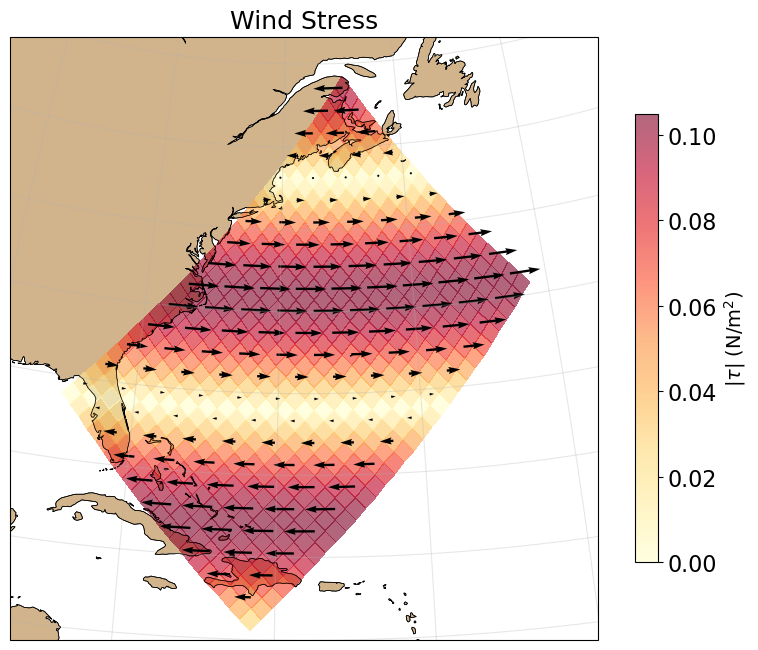

In [2]:
taux_i = ds_t["sozotaux"].mean("time_counter").values  # along i-axis
tauy_j = ds_t["sometauy"].mean("time_counter").values  # along j-axis

# Rotate from grid (i,j) to geographic (east, north)
taux_east, tauy_north = rotate_to_geo(taux_i, tauy_j, grid_angle)

tau_mag = np.sqrt(taux_east**2 + tauy_north**2)
tau_mag_masked = np.where(interior_t, tau_mag, np.nan)

fig, ax = plt.subplots(figsize=(8, 7), subplot_kw=dict(projection=proj))
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor="tan", edgecolor="k", linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.gridlines(draw_labels=False, alpha=0.3)

pcm = ax.pcolormesh(
    lon, lat, tau_mag_masked, shading="auto", cmap="YlOrRd",
    alpha=0.6, transform=ccrs.PlateCarree(),
)
fig.colorbar(pcm, ax=ax, label="|$\\tau$| (N/m$^2$)", shrink=0.7)

skip = 2
ax.quiver(
    lon[::skip, ::skip], lat[::skip, ::skip],
    np.where(interior_t[::skip, ::skip], taux_east[::skip, ::skip], np.nan),
    np.where(interior_t[::skip, ::skip], tauy_north[::skip, ::skip], np.nan),
    color="k", scale=2.0, width=0.004, transform=ccrs.PlateCarree(),
)
ax.set_title("Wind Stress")
fig.tight_layout()

## Total kinetic energy time series

Volume-integrated KE: $\text{KE} = \frac{1}{2}\rho_0 \sum_{i,j,k}
(u^2 + v^2)\, e1t\, e2t\, e3t\, \text{tmask}$

U and V are interpolated to the T-grid (simple average of neighbours)
before computing KE. Uses $\rho_0 = 1026$ kg/m³.

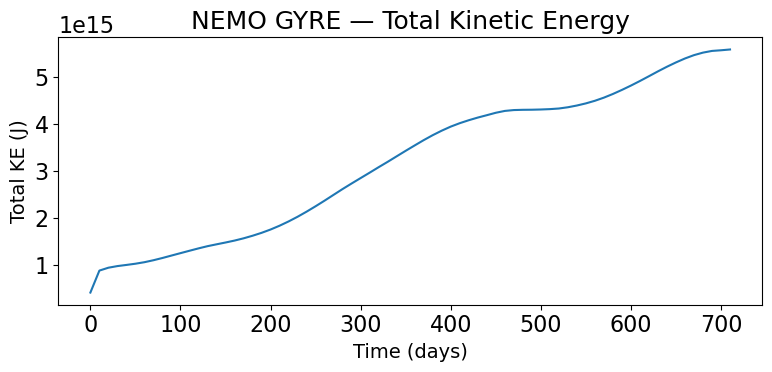

In [3]:
rho0 = 1026.0

u_raw = ds_u["vozocrtx"].values  # (t, z, y, x)
v_raw = ds_v["vomecrty"].values  # (t, z, y, x)

# Cell volume: e1t * e2t * e3t * tmask
cell_vol = cell_area[np.newaxis, :, :] * e3t[:, np.newaxis, np.newaxis] * tmask  # (z, y, x)

nt = u_raw.shape[0]
ke_ts = np.zeros(nt)
for t in range(nt):
    # Interpolate U to T-grid: average i and i-1
    u_on_t = 0.5 * (u_raw[t, :, :, :-1] + u_raw[t, :, :, 1:])
    # Interpolate V to T-grid: average j and j-1
    v_on_t = 0.5 * (v_raw[t, :, :-1, :] + v_raw[t, :, 1:, :])
    # Common interior shape
    nz, ny, nx = cell_vol.shape
    ny2, nx2 = min(ny, u_on_t.shape[1], v_on_t.shape[1]), min(nx, u_on_t.shape[2], v_on_t.shape[2])
    u2 = u_on_t[:, :ny2, :nx2] ** 2
    v2 = v_on_t[:, :ny2, :nx2] ** 2
    cv = cell_vol[:, :ny2, :nx2]
    ke_ts[t] = 0.5 * rho0 * np.sum((u2 + v2) * cv)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time_days, ke_ts)
ax.set_xlabel("Time (days)")
ax.set_ylabel("Total KE (J)")
ax.set_title("NEMO GYRE — Total Kinetic Energy")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
fig.tight_layout()